In [1]:
import os
import yaml
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xopt.vocs import VOCS
from xopt.generators.bayesian.models.standard import StandardModelConstructor

from botorch.models.transforms import Normalize

In [8]:
f_names = ["exploration_2_nd_filter.yml", "optimization_1.yml", "optimization_2.yml"]
dfs = []
for name in f_names:
    with open(name, "r") as file:
        f = yaml.safe_load(file)
        dfs += [pd.DataFrame(f["data"])]

data = pd.concat(dfs, ignore_index=True)
data = data.dropna(subset=["total_rms_size"])
data["total_rms_size"] = data["total_rms_size"] - 57.224

vocs = VOCS(**f["vocs"])

## Process data frame points
exp_data_x = torch.tensor(data[vocs.variable_names].to_numpy()).double()
exp_data_y = torch.tensor(data[vocs.objective_names].to_numpy()).double()

data.iloc[np.nanargmin(data["total_rms_size"].to_numpy())][vocs.variable_names]

AWA:Bira3Ctrl:Ch03      -0.806105
AWA:Bira3Ctrl:Ch04      -0.776121
AWA:Bira3Ctrl:Ch05       1.705201
AWA:Bira3Ctrl:Ch06       0.131568
AWA:DAC0:Ch08            4.929338
AWA:Drive:DS1:Ctrl      502.17009
AWA:Drive:DS3:Ctrl     208.105682
AWALLRF:K1:SetPhase    250.911686
Name: 48, dtype: object

In [3]:
class TransformedModel(nn.Module):
    def __init__(self, model, x_transformer, y_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.x_transformer = x_transformer
        self.y_transformer = y_transformer
    
    def forward(self, x):
        x = self.x_transformer(x)
        x = self.model(x)
        x = self.y_transformer.untransform(x)
        return x

Text(0, 0.5, 'pred')

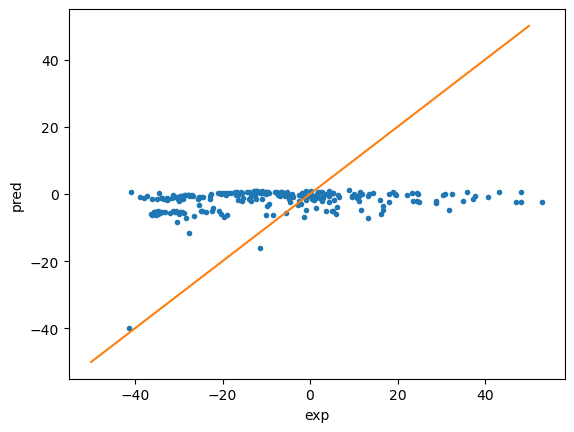

In [4]:
model = torch.load("fitted_model.pt")

pred_y = model(exp_data_x)

fig,ax = plt.subplots()
ax.plot(exp_data_y, pred_y.detach(),".")
x = np.linspace(-50,50,100)
ax.plot(x,x)
ax.set_xlabel("exp")
ax.set_ylabel("pred")